In [1]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
from croissant.healpix import grid2healpix
import faraday as fd

#%matplotlib notebook

## Simulation Parameters and Constants

In [2]:
FREQ = 30  # minimum frequency in MHz
NCHANS = 64  # frequency channels
NSIDE = 128
THETA_MAX = 5  # extent of point src in degrees
RM = 250  # rotation measure

frequencies = np.linspace(0, 25/1e3, NCHANS) + FREQ  # 64 channels of 390 Hz width
c = 299792458  # m / s

## Spectral Response

5.002501250625513e-05 2000


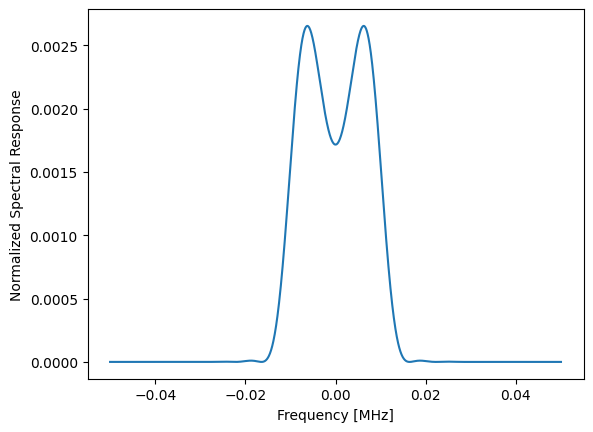

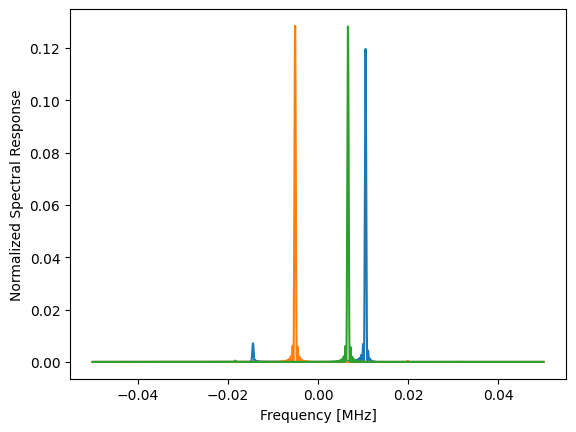

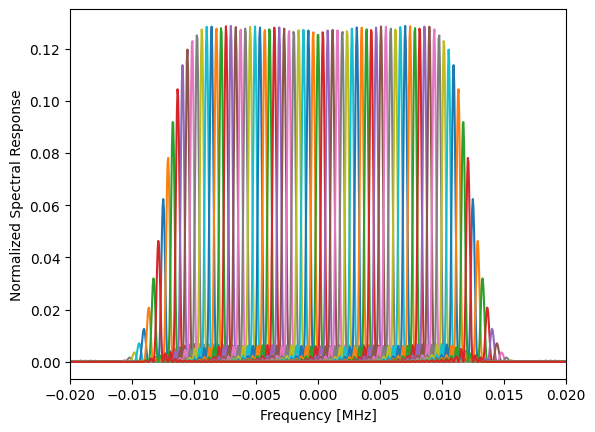

In [27]:
spec = np.loadtxt("../data/zoom_response_4tap.txt")
offset = spec[:, 0] / 1e3 # spacing in MHz
print(offset[1]-offset[0], len(offset))
# normalize response
spec = spec[:, 1:] / spec[:, 1:].sum(axis=0, keepdims=True)

plt.figure()
plt.plot(offset, spec[:, 0])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(offset, spec[:, -5])
plt.plot(offset, spec[:, 20])
plt.plot(offset, spec[:, 50])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.show()

plt.figure()
plt.plot(offset, spec[:, 1:])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Normalized Spectral Response")
plt.xlim(-20/1e3, 20/1e3)
plt.show()

## Short Dipole + Linearly Polarized Source - analytic result

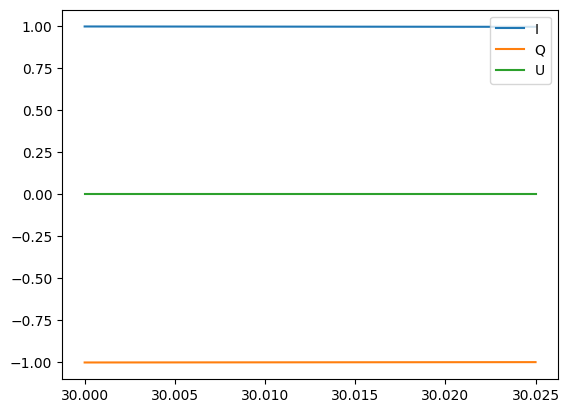

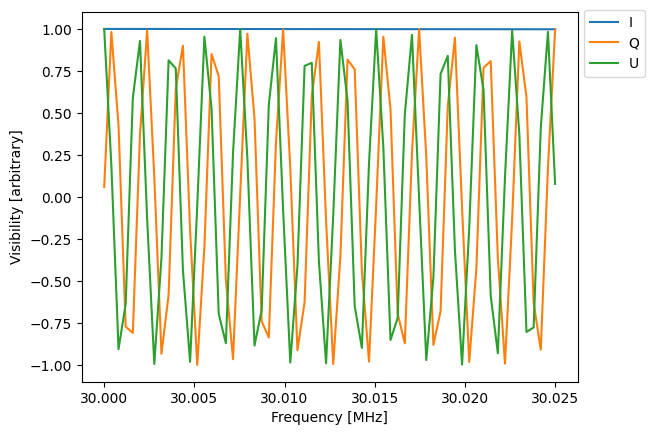

In [4]:
#alpha0 = -RM * (c/23e9)**2  # ref freq where alpha is 0
alpha0 = 0
def stokes_analytic(frequencies=frequencies, faraday=True, rm=RM, alpha0=alpha0):
    wave = c / (frequencies * 1e6)  # wavelength in m
    if faraday:
        arg = 2 * (rm * wave**2 + alpha0)
    else:
        arg = 2 * alpha0 * np.ones(frequencies.size)
    s = np.array([np.ones(frequencies.size), -np.cos(arg), -np.sin(arg)])
    return s * (frequencies[None]/frequencies.min())**(-2.5)

nu = np.linspace(0, 25/1e3, 64) + FREQ  # 25 kHz bw split in NCHANS
stokes = stokes_analytic(frequencies=nu, faraday=False)
stokes_rot = stokes_analytic(frequencies=nu, faraday=True)

plt.figure()
plt.plot(nu, stokes[0], label="I")
plt.plot(nu, stokes[1], label="Q")
plt.plot(nu, stokes[2], label="U")
plt.legend()
plt.show()


plt.figure()
plt.plot(nu, stokes_rot[0], label="I")
plt.plot(nu, stokes_rot[1], label="Q")
plt.plot(nu, stokes_rot[2], label="U")
plt.legend(bbox_to_anchor=[1.15, 1.025])
plt.xlabel("Frequency [MHz]")
plt.ylabel("Visibility [arbitrary]")
plt.show()

## Short Dipole Beam

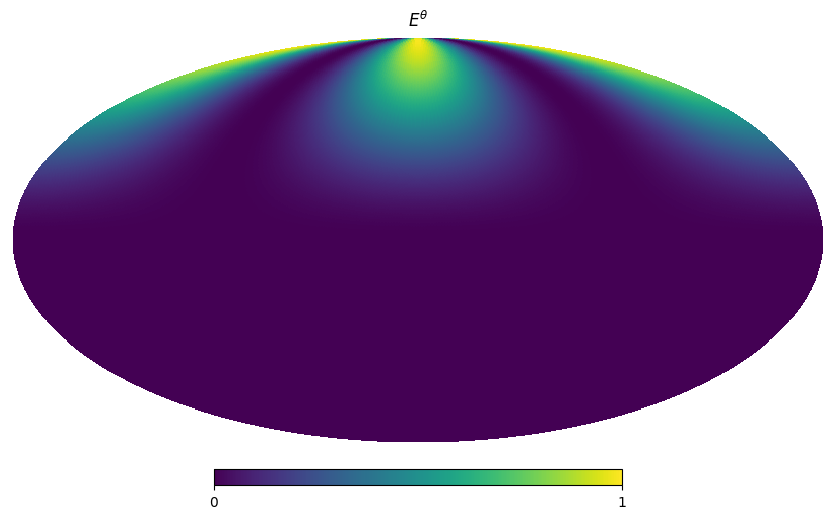

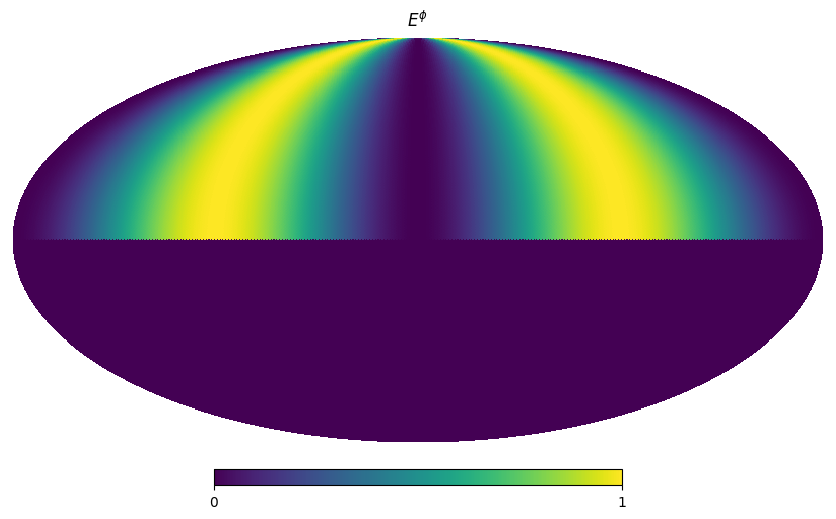

In [5]:
beam = fd.ShortDipole(NSIDE, frequency=FREQ)
hp.mollview(beam.beam_X[0]**2, title="$E^{\\theta}$", min=0, max=1)
plt.show()
hp.mollview(beam.beam_X[1]**2, title="$E^{\\phi}$", min=0, max=1)
plt.show()

# hp.mollview(beam.beam_Y[0]**2, title="$E^{\\theta}$", min=0, max=1)
# plt.show()
# hp.mollview(beam.beam_Y[1]**2, title="$E^{\\phi}$", min=0, max=1)
# plt.show()

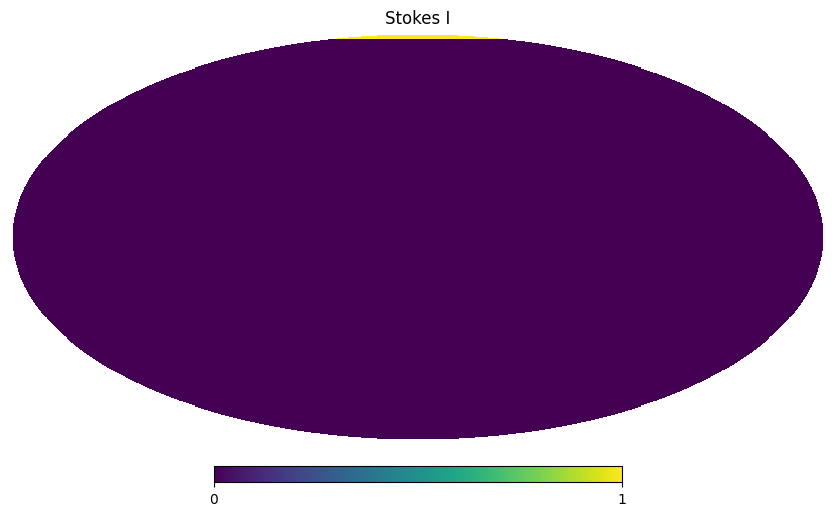

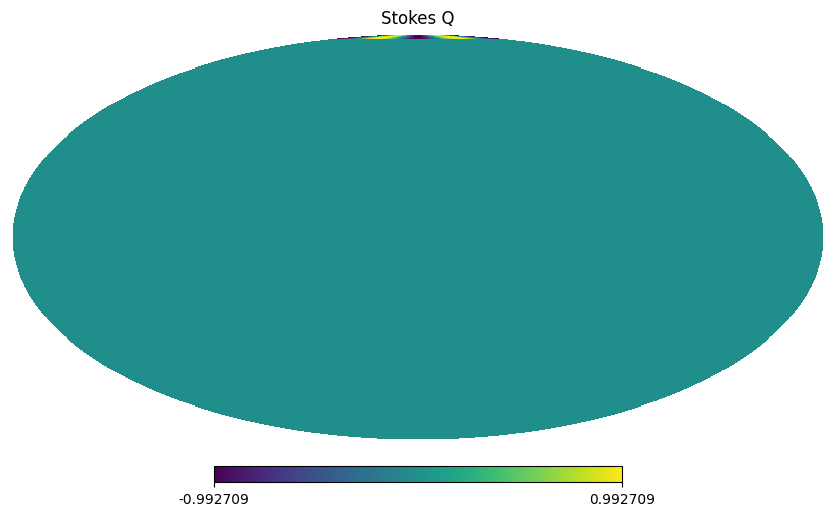

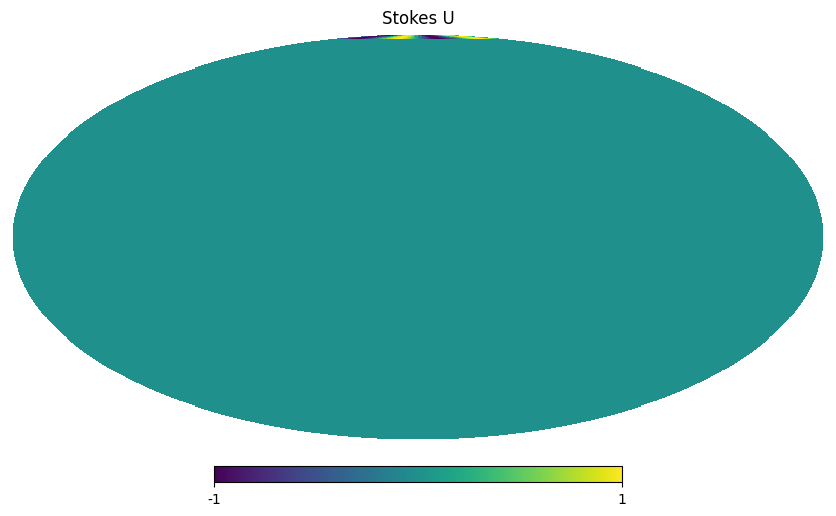

(1, 3, 196608)
(1, 3, 364)
(64, 3, 364)


In [6]:
sky = fd.Sky.zeros(NSIDE, freq=FREQ)
sky.add_point_source(extent=THETA_MAX)  # 5 deg source at zenith
hp.mollview(sky.stokes[0, 0], title="Stokes I")
plt.show()
hp.mollview(sky.stokes[0, 1], title="Stokes Q")
plt.show()
hp.mollview(sky.stokes[0, 2], title="Stokes U")
plt.show()

print(sky.stokes.shape)
pix = sky.del_dark_pixels()  # pixels to keep
beam.del_pix(pix)
print(sky.stokes[..., sky.bright_pixels].shape)
sky.power_law(frequencies, -2.5)
print(sky.stokes.shape)

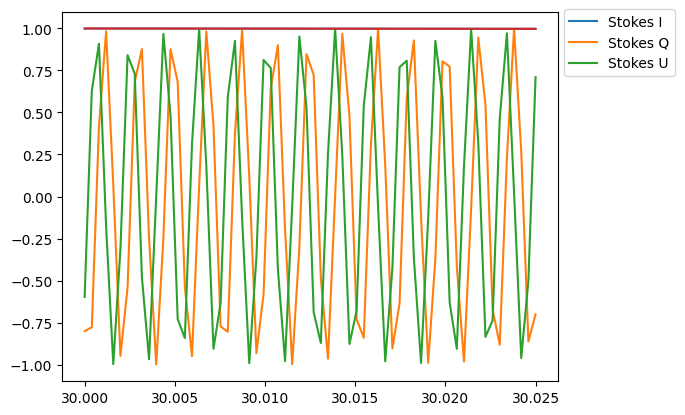

In [7]:
sky.apply_faraday(RM)

plt.figure()
plt.plot(sky.freq, sky.stokes_rot[:, 0, 10], label="Stokes I")
plt.plot(sky.freq, sky.stokes_rot[:, 1, 10], label="Stokes Q")
plt.plot(sky.freq, sky.stokes_rot[:, 2, 10], label="Stokes U")
plt.plot(sky.freq, np.sqrt(sky.stokes_rot[:, 1, 10]**2 + sky.stokes_rot[:, 2, 10]**2))
plt.legend(bbox_to_anchor=[1.25, 1.025])
plt.show()

In [8]:
sim = fd.Simulator(beam, sky)
sim.run(channelize=False)

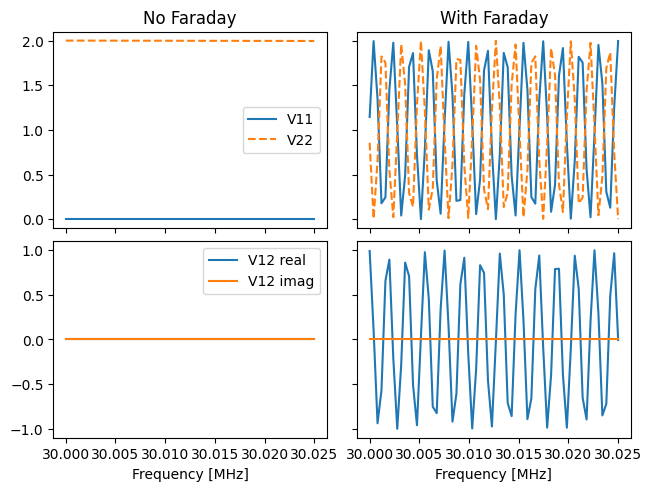

In [9]:
fd.sim.plot_vis(frequencies, sim.vis, sim.vis_rot)

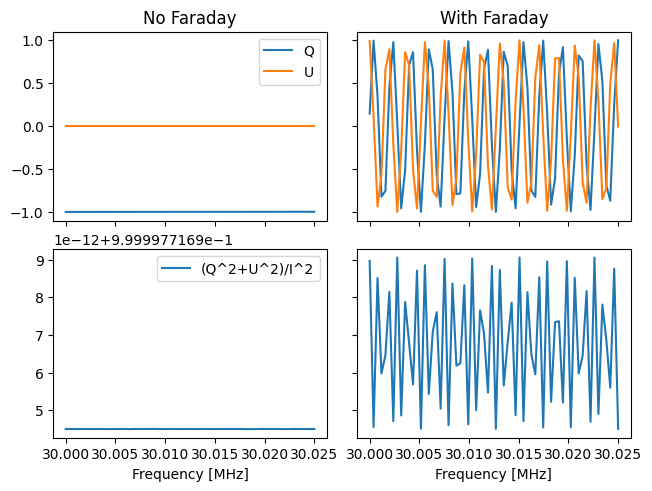

In [10]:
fd.sim.plot_stokes(frequencies, sim.stokes, sim.stokes_rot)

## Compare analytic and simulated

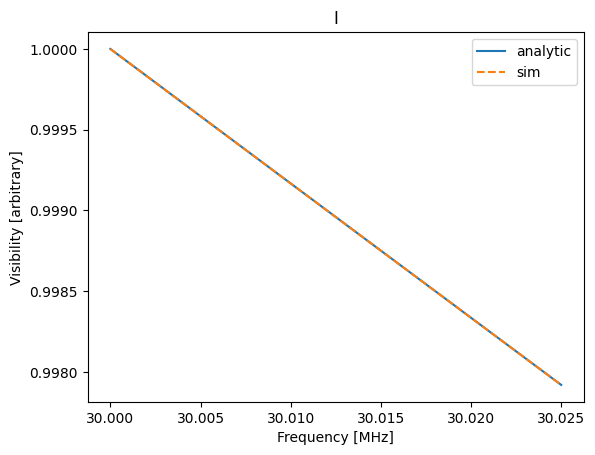

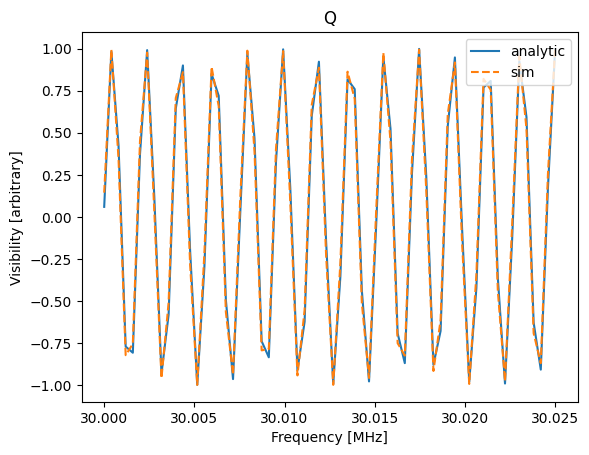

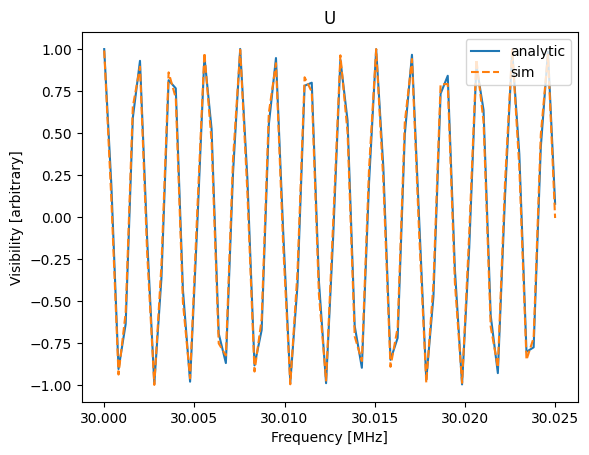

In [11]:
labels = ["I", "Q", "U"]
for i in range(3):
    plt.figure()
    plt.plot(nu, stokes_rot[i], label="analytic")
    plt.plot(nu, sim.stokes_rot[i], label="sim", ls="--")
    plt.legend(loc="upper right")
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Visibility [arbitrary]")
    plt.title(labels[i])
    plt.show()

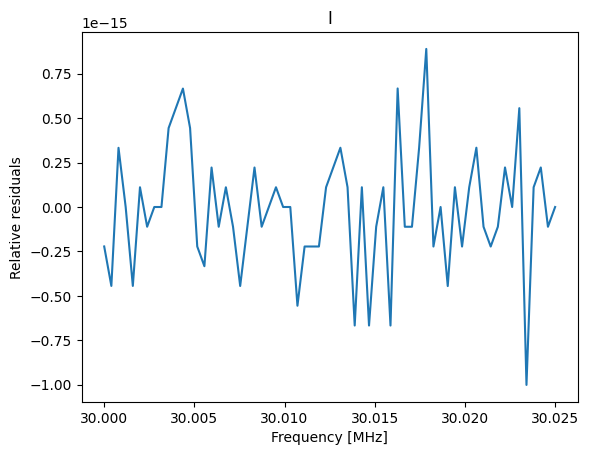

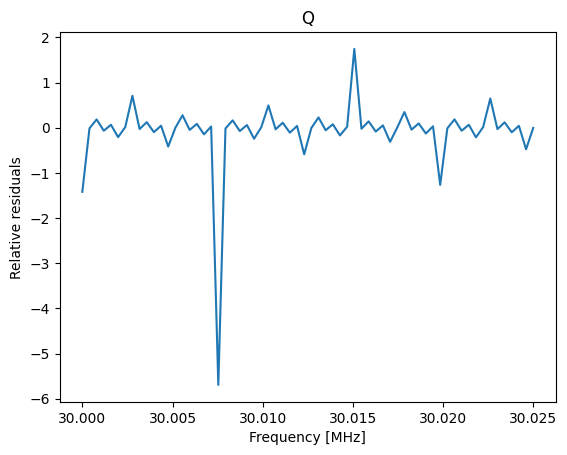

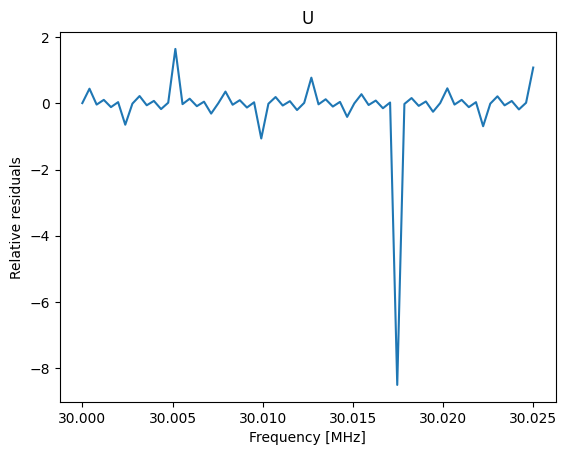

In [13]:
labels = ["I", "Q", "U"]
for i in range(3):
    plt.figure()
    plt.plot(nu, (stokes_rot[i]-sim.stokes_rot[i]) / stokes_rot[i])
    plt.xlabel("Frequency [MHz]")
    plt.ylabel("Relative residuals")
    plt.title(labels[i])
    plt.show()

In [14]:
print(np.max(np.abs(stokes_rot-sim.stokes_rot)))

0.08488287354531587


# LuSEE Beam + Zenith Source

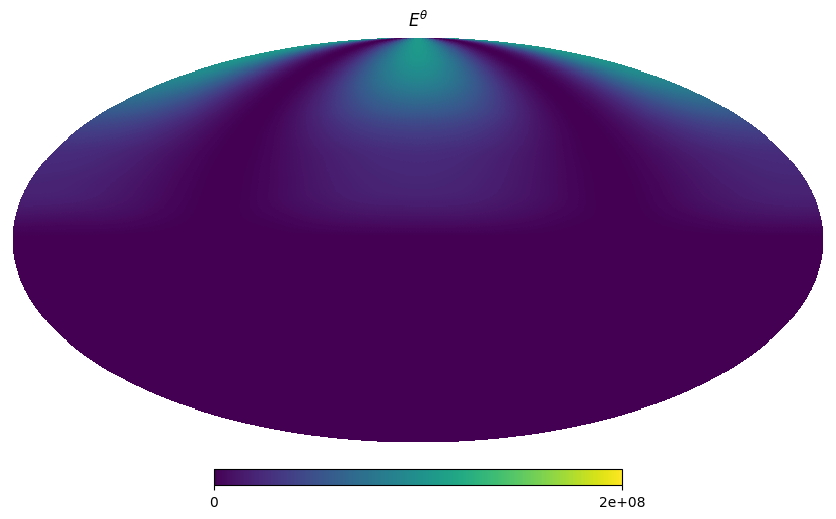

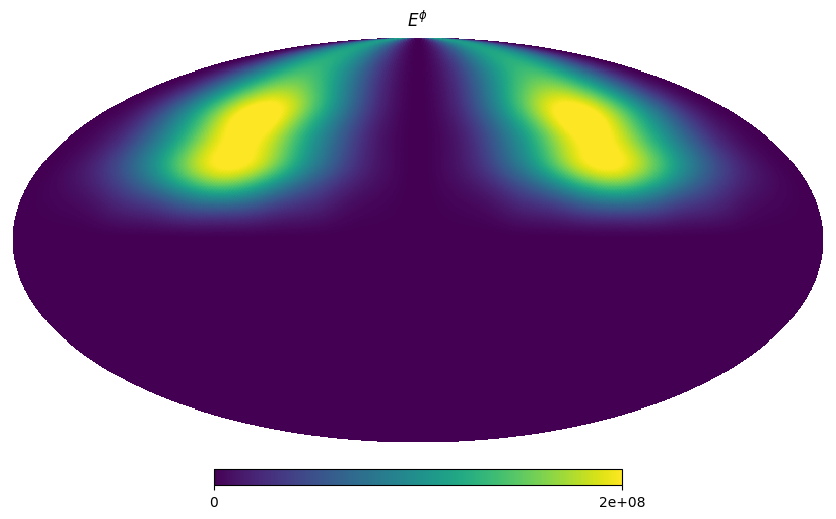

In [15]:
# lusee beam
def read_beam(fname, freq=FREQ):
    with fits.open(fname) as hdul:
        E_theta = hdul["Etheta_real"].data + 1j * hdul["Etheta_imag"].data
        E_phi = hdul["Ephi_real"].data + 1j * hdul["Ephi_imag"].data
        ix = np.argwhere(hdul["freq"].data == freq)[0, 0]
        E_theta = E_theta[ix]
        E_phi = E_phi[ix]

    lusee_Y = np.array([E_theta.real, E_theta.imag, E_phi.real, E_phi.imag])[:, :, :-1]
    lusee_Y = np.concatenate((lusee_Y, np.zeros_like(lusee_Y)[:, :-1, :]), axis=1)
    #lusee_Y /= np.abs(lusee_Y).max(axis=(1,2))[:, None, None]
    return lusee_Y
    
lusee_Y = read_beam("../data/hfss_lbl_3m_75deg.2port.fits")  # along Y axis
lusee_X = np.roll(lusee_Y, -90, axis=-1)
lusee_X = grid2healpix(lusee_X, NSIDE)
lusee_Y = grid2healpix(lusee_Y, NSIDE)

beam_X = np.array([lusee_X[0] + 1j * lusee_X[1], lusee_X[2] + 1j * lusee_X[3]])
beam_Y = np.array([lusee_Y[0] + 1j * lusee_Y[1], lusee_Y[2] + 1j * lusee_Y[3]])

beam = fd.Beam(beam_X=beam_X, beam_Y=beam_Y, frequency=FREQ)

hp.mollview(np.abs(beam.beam_X[0])**2, title="$E^{\\theta}$", min=0, max=2e8)
plt.show()
hp.mollview(np.abs(beam.beam_X[1])**2, title="$E^{\\phi}$", min=0, max=2e8)
plt.show()

In [16]:
frequencies = offset - offset[0] + FREQ

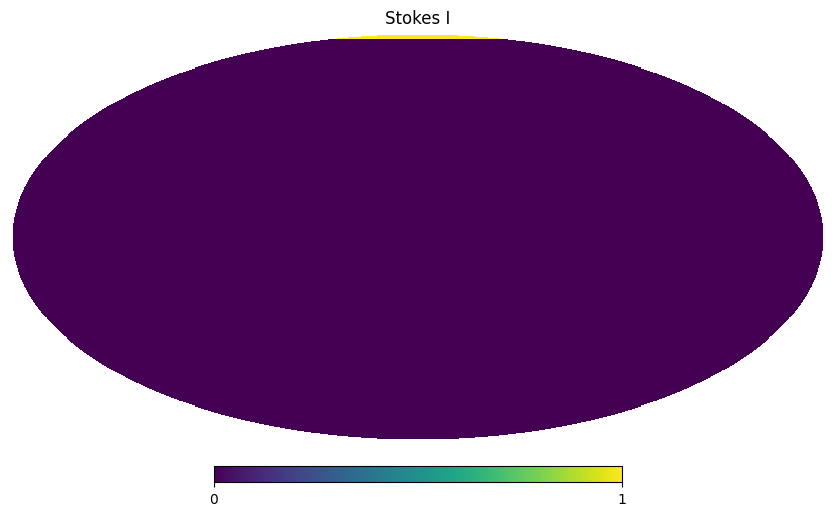

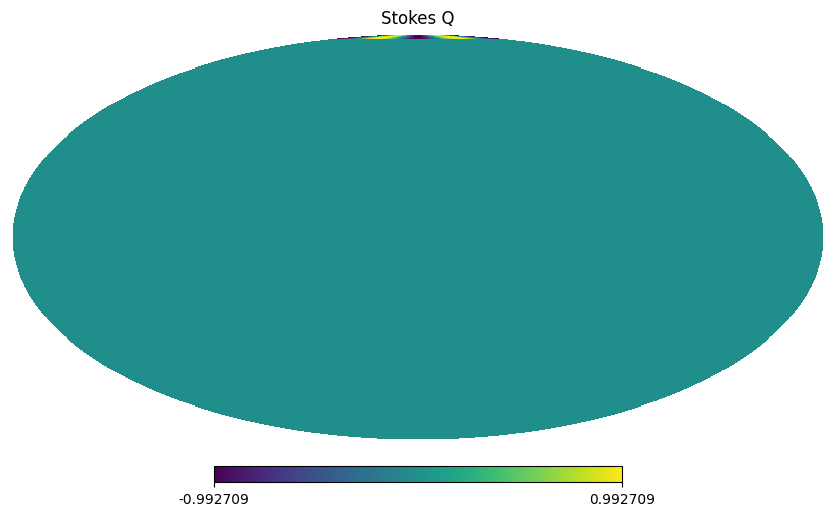

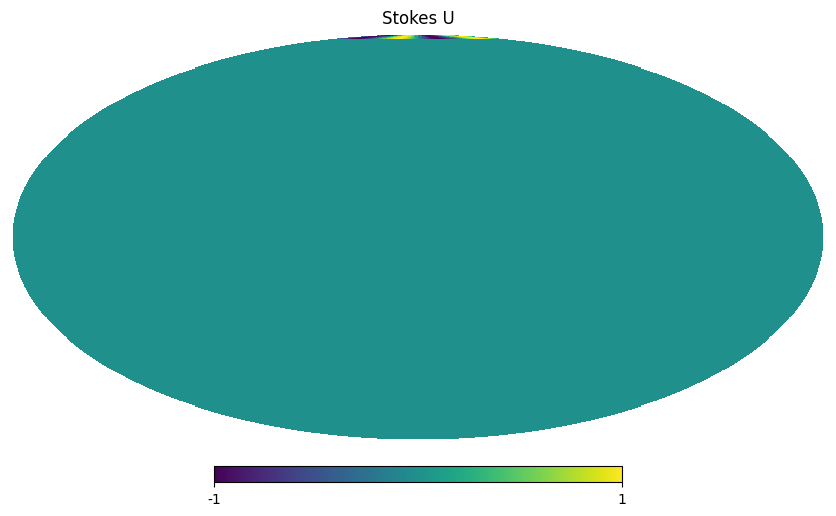

(1, 3, 196608)
(1, 3, 364)
(2000, 3, 364)


In [17]:
sky = fd.Sky.zeros(NSIDE, freq=FREQ)
sky.add_point_source(extent=THETA_MAX)  # 5 deg source at zenith
hp.mollview(sky.stokes[0, 0], title="Stokes I")
plt.show()
hp.mollview(sky.stokes[0, 1], title="Stokes Q")
plt.show()
hp.mollview(sky.stokes[0, 2], title="Stokes U")
plt.show()

print(sky.stokes.shape)
pix = sky.del_dark_pixels()  # pixels to keep
beam.del_pix(pix)
print(sky.stokes[..., sky.bright_pixels].shape)
sky.power_law(frequencies, -2.5)
print(sky.stokes.shape)

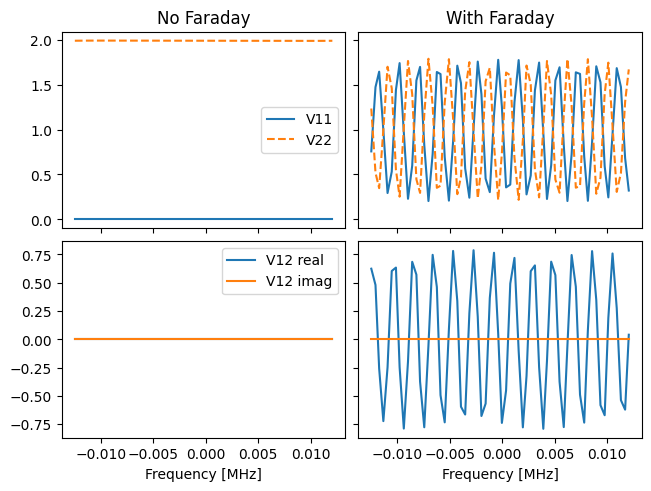

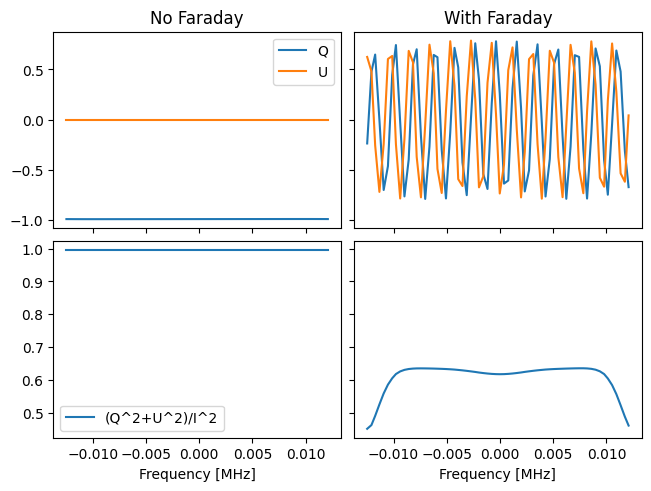

In [21]:
sky.apply_faraday(RM)
sim = fd.Simulator(beam, sky)
sim.run()
fd.sim.plot_vis(sim.freq, sim.vis, sim.vis_rot)
fd.sim.plot_stokes(sim.freq, sim.stokes, sim.stokes_rot)

In [ ]:
a